In [14]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score
import json
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score


In [3]:
def load_and_preprocess_image(full_path, target_size):
    img = load_img(full_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array)
    return preprocessed_img

In [4]:
def get_data(excel_path, base_dir, image_size=(32, 32)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    X = np.array([load_and_preprocess_image(os.path.join(base_dir, path), image_size) for path in df['image_path'].values])
    y = df[class_columns].values
    return X, y, df

In [5]:
train_excel_path = "D:/misahub/Dataset/Dataset/training/training_data.xlsx"
val_excel_path = "D:/misahub/Dataset/Dataset/validation/validation_data.xlsx"
base_dir = "D:/misahub/Dataset/Dataset"  
image_size = (32, 32)  
batch_size = 4096
epochs = 10

In [6]:
X_train, y_train, _ = get_data(train_excel_path, base_dir, image_size=image_size)
X_val, y_val, val_df = get_data(val_excel_path, base_dir, image_size=image_size)

In [7]:
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weights_dict)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 196s 20s/step - accuracy: 0.1633 - loss: 13.1751 - val_accuracy: 0.5651 - val_loss: 7.0220
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 222s 23s/step - accuracy: 0.4633 - loss: 5.3237 - val_accuracy: 0.5566 - val_loss: 3.8826
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 203s 21s/step - accuracy: 0.5757 - loss: 3.0460 - val_accuracy: 0.4854 - val_loss: 3.5859
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 205s 21s/step - accuracy: 0.5800 - loss: 2.0655 - val_accuracy: 0.5226 - val_loss: 2.8578
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 248s 26s/step - accuracy: 0.6108 - loss: 1.5496 - val_accuracy: 0.6002 - val_loss: 2.0796
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 248s 25s/step - accuracy: 0.6518 - loss: 1.2048 - val_accuracy: 0.6056 - val_loss: 1.8884
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 261s 27s/step - accuracy: 0.6758 - loss: 0.9552 - val_accuracy: 0.6526 - val_loss: 1.5981
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 262s 27s/step - accuracy: 0.7078 - loss: 0.7704 - val_accuracy: 0

In [15]:
model.save('model.keras')

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import json
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score

def save_predictions_to_excel(image_paths, y_pred, output_path):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)


def calculate_specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

def generate_metrics_report(y_true, y_pred):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}
    
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)
    
    auc_roc_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            auc_roc_scores[class_name] = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc_roc_scores[class_name] = 0.0  
    
    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc
    
    specificity_scores = {}
    for i, class_name in enumerate(class_columns):
        specificity_scores[class_name] = calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int))  # Thresholding y_pred
    
    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity
    
    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            average_precision_scores[class_name] = auc(recall, precision)
        except ValueError:
            average_precision_scores[class_name] = 0.0  
    
    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision
    
    sensitivity_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            sensitivity_scores[class_name] = recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            sensitivity_scores[class_name] = 0.0  
    
    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity
    
    f1_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            f1_scores[class_name] = f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            f1_scores[class_name] = 0.0  
    
    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score
    balanced_accuracy_scores = balanced_accuracy_score(y_true_classes, y_pred_classes)

    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy_scores
    
    metrics_report_json = json.dumps(metrics_report, indent=4)
    return metrics_report_json


In [17]:
y_val_pred = model.predict(X_val)
metrics_rep=generate_metrics_report(y_val,y_val_pred)
print(metrics_rep)

505/505 ━━━━━━━━━━━━━━━━━━━━ 77s 145ms/step
{
    "Angioectasia": {
        "precision": 0.33962264150943394,
        "recall": 0.5070422535211268,
        "f1-score": 0.4067796610169492,
        "support": 497.0
    },
    "Bleeding": {
        "precision": 0.5125,
        "recall": 0.5710306406685237,
        "f1-score": 0.5401844532279315,
        "support": 359.0
    },
    "Erosion": {
        "precision": 0.29219143576826195,
        "recall": 0.4017316017316017,
        "f1-score": 0.33831571272329564,
        "support": 1155.0
    },
    "Erythema": {
        "precision": 0.13002364066193853,
        "recall": 0.37037037037037035,
        "f1-score": 0.19247594050743658,
        "support": 297.0
    },
    "Foreign Body": {
        "precision": 0.33527696793002915,
        "recall": 0.6764705882352942,
        "f1-score": 0.44834307992202727,
        "support": 340.0
    },
    "Lymphangiectasia": {
        "precision": 0.3793103448275862,
        "recall": 0.5131195335276968,


In [20]:
output_val_predictions="validation_excel.xlsx"
save_predictions_to_excel(val_df['image_path'].values, y_val_pred, output_val_predictions)

In [21]:
train_excel_path = 'D:/misahub/Dataset/Dataset/training/training_data.xlsx'
val_excel_path = 'D:/misahub/Dataset/Dataset/validation/validation_data.xlsx'
train_df = pd.read_excel(train_excel_path)
val_df = pd.read_excel(val_excel_path)

In [22]:
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
class_columns_excl_normal = [col for col in class_columns if col != 'Normal']

C:\Users\HP\AppData\Local\Temp\ipykernel_11768\3172415231.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))
C:\Users\HP\AppData\Local\Temp\ipykernel_11768\3172415231.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))


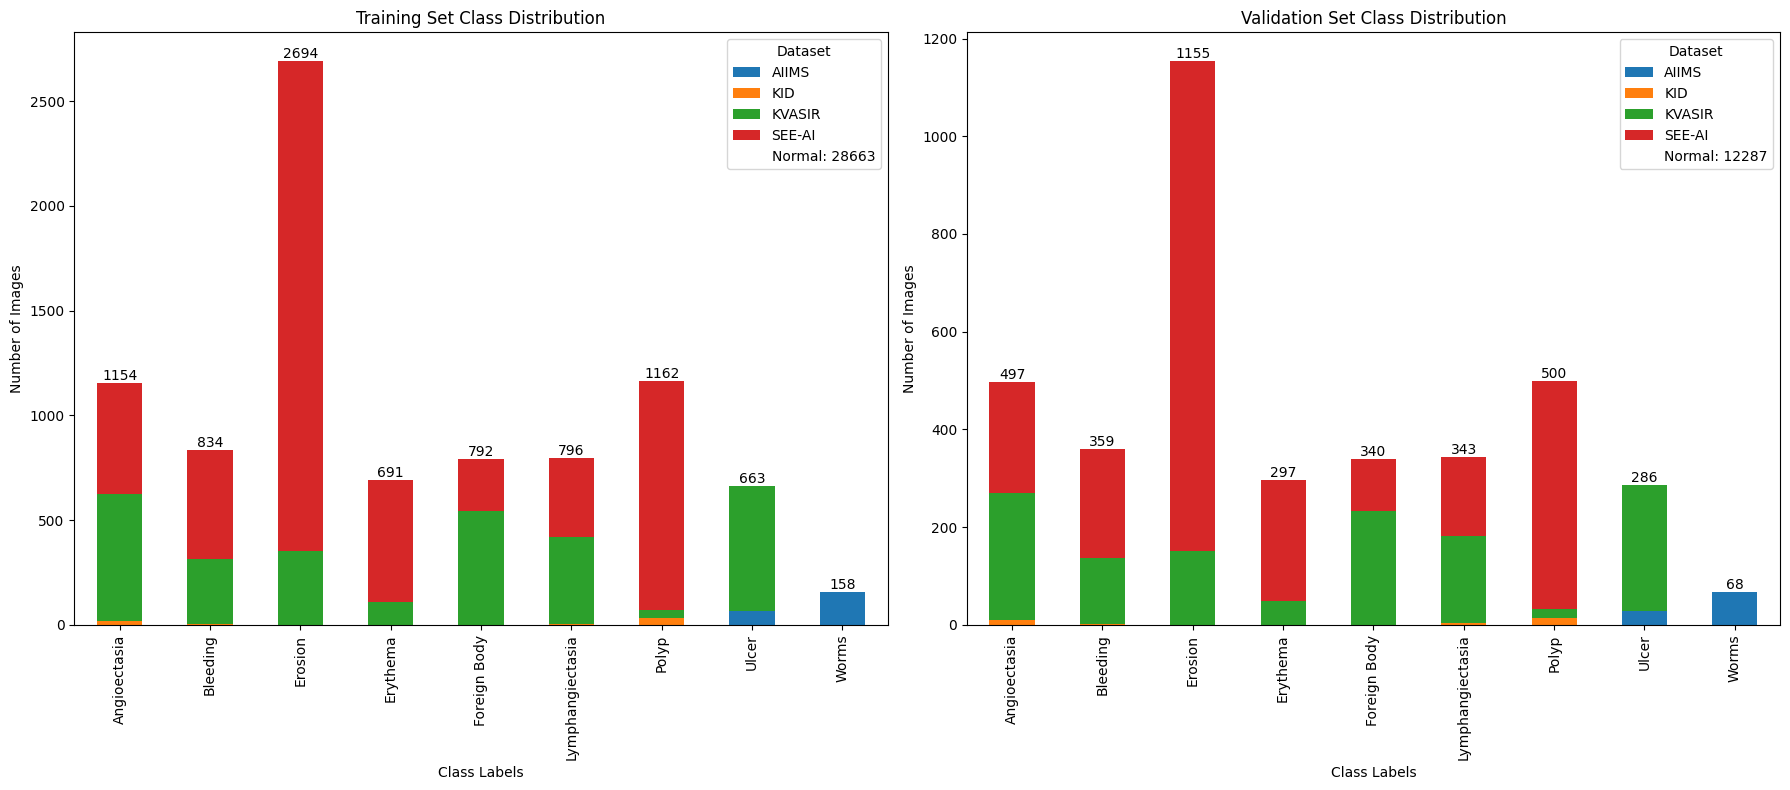

In [24]:
train_distribution_per_source = train_df.groupby('Dataset')[class_columns_excl_normal].sum().T
val_distribution_per_source = val_df.groupby('Dataset')[class_columns_excl_normal].sum().T
train_distribution = train_df[class_columns_excl_normal].sum()
val_distribution = val_df[class_columns_excl_normal].sum()

train_normal_count = train_df['Normal'].sum()
val_normal_count = val_df['Normal'].sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

handles, labels = ax[0].get_legend_handles_labels()
handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))
labels.append(f'Normal: {train_normal_count}')
ax[0].legend(handles, labels, title='Dataset')

val_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

handles, labels = ax[1].get_legend_handles_labels()
handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))
labels.append(f'Normal: {val_normal_count}')
ax[1].legend(handles, labels, title='Dataset')

plt.tight_layout()
plt.savefig('graph1.png')
plt.show()

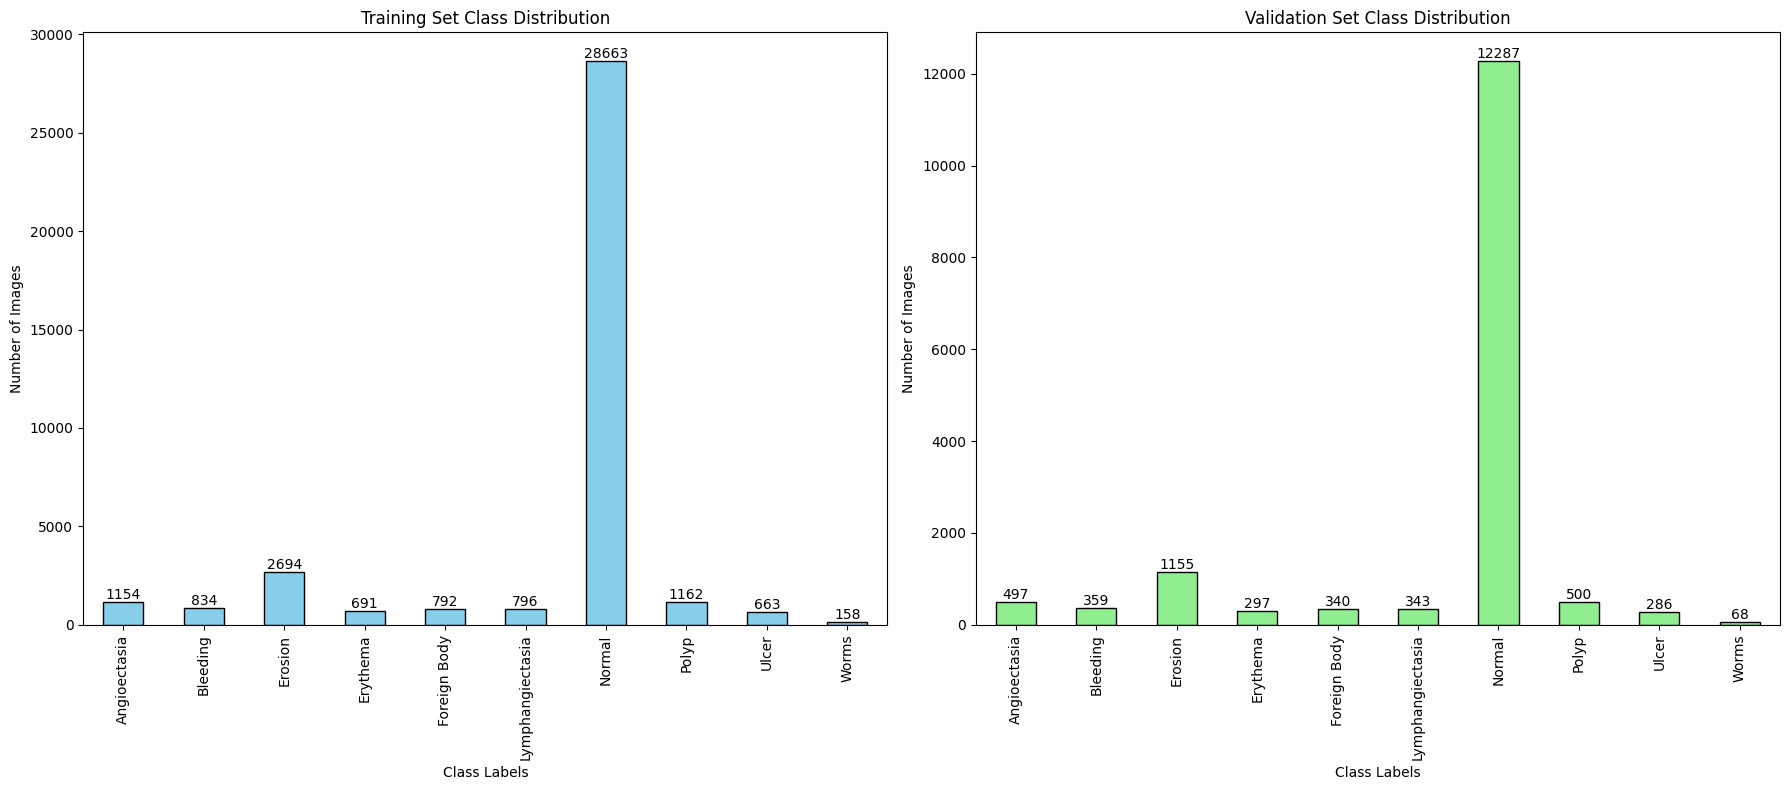

In [25]:
train_distribution = train_df[class_columns].sum()
val_distribution = val_df[class_columns].sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph2.png')
plt.show()

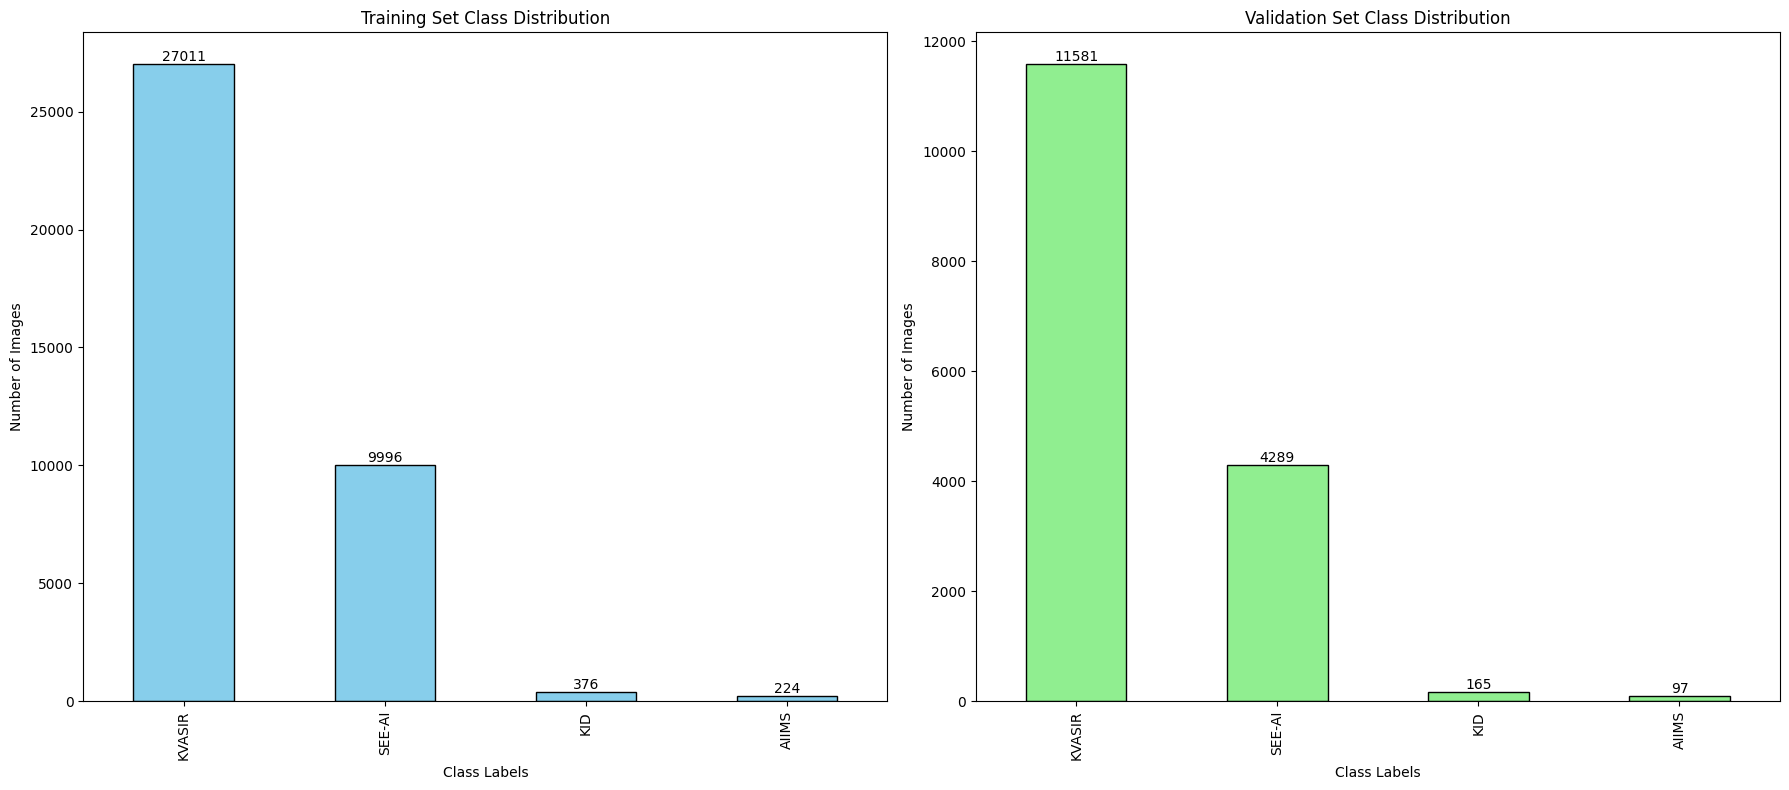

In [26]:
train_df = train_df.dropna(subset=['image_path', 'Dataset'])
val_df = val_df.dropna(subset=['image_path', 'Dataset'])

train_distribution = train_df['Dataset'].value_counts()
val_distribution = val_df['Dataset'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph3.png')
plt.show()

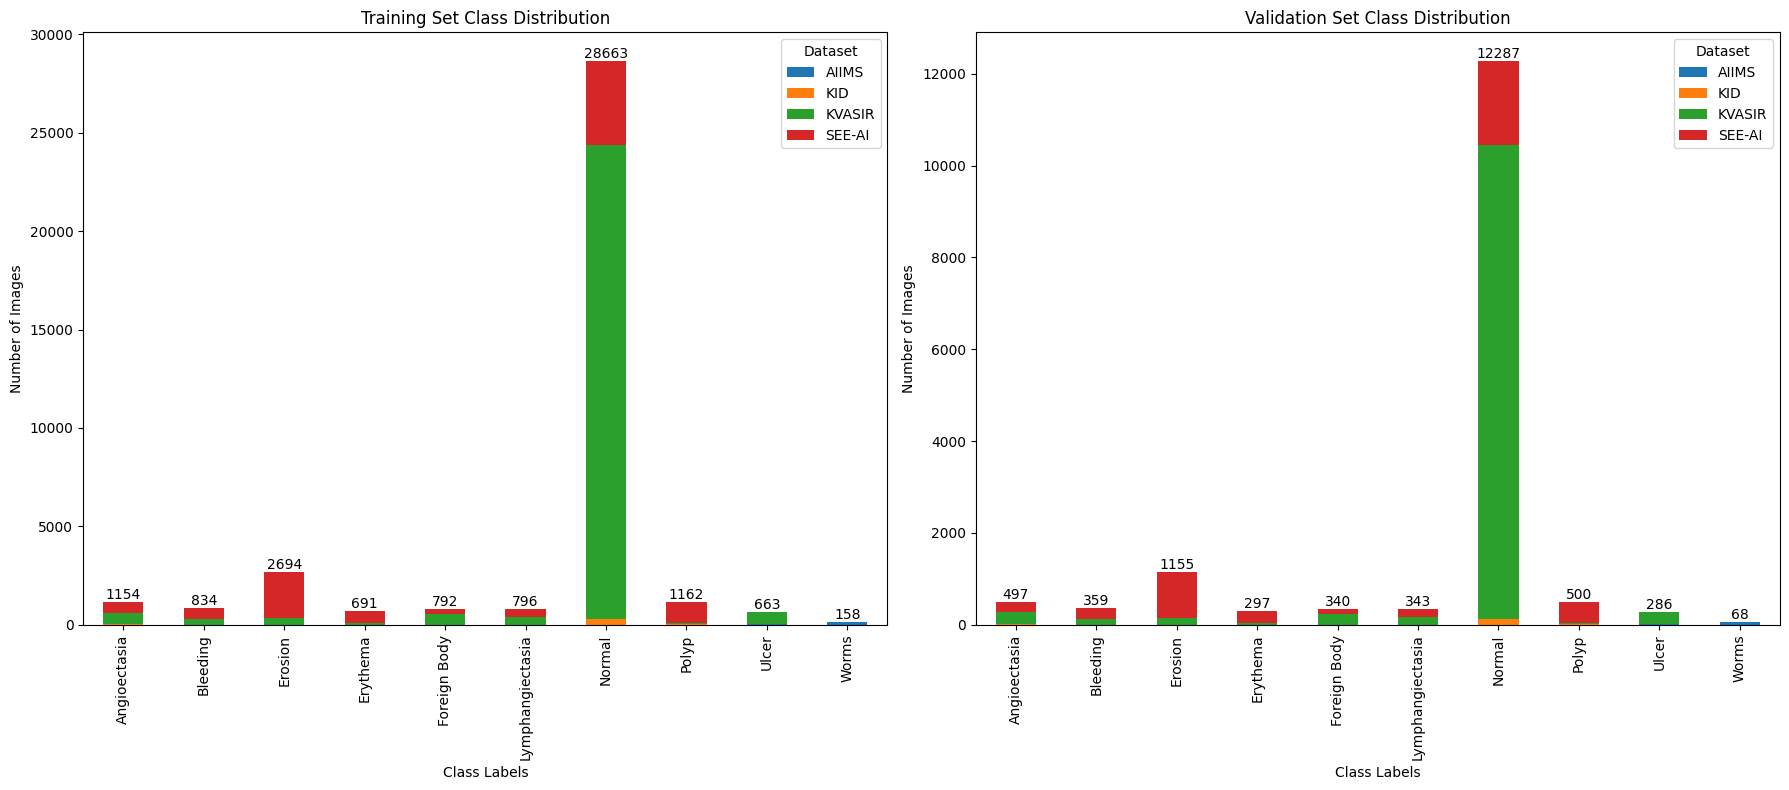

In [27]:
train_df = pd.read_excel(train_excel_path)
val_df = pd.read_excel(val_excel_path)
train_distribution_per_source = train_df.groupby('Dataset')[class_columns].sum().T
val_distribution_per_source = val_df.groupby('Dataset')[class_columns].sum().T
train_distribution = train_df[class_columns].sum()
val_distribution = val_df[class_columns].sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph4.png')
plt.show()

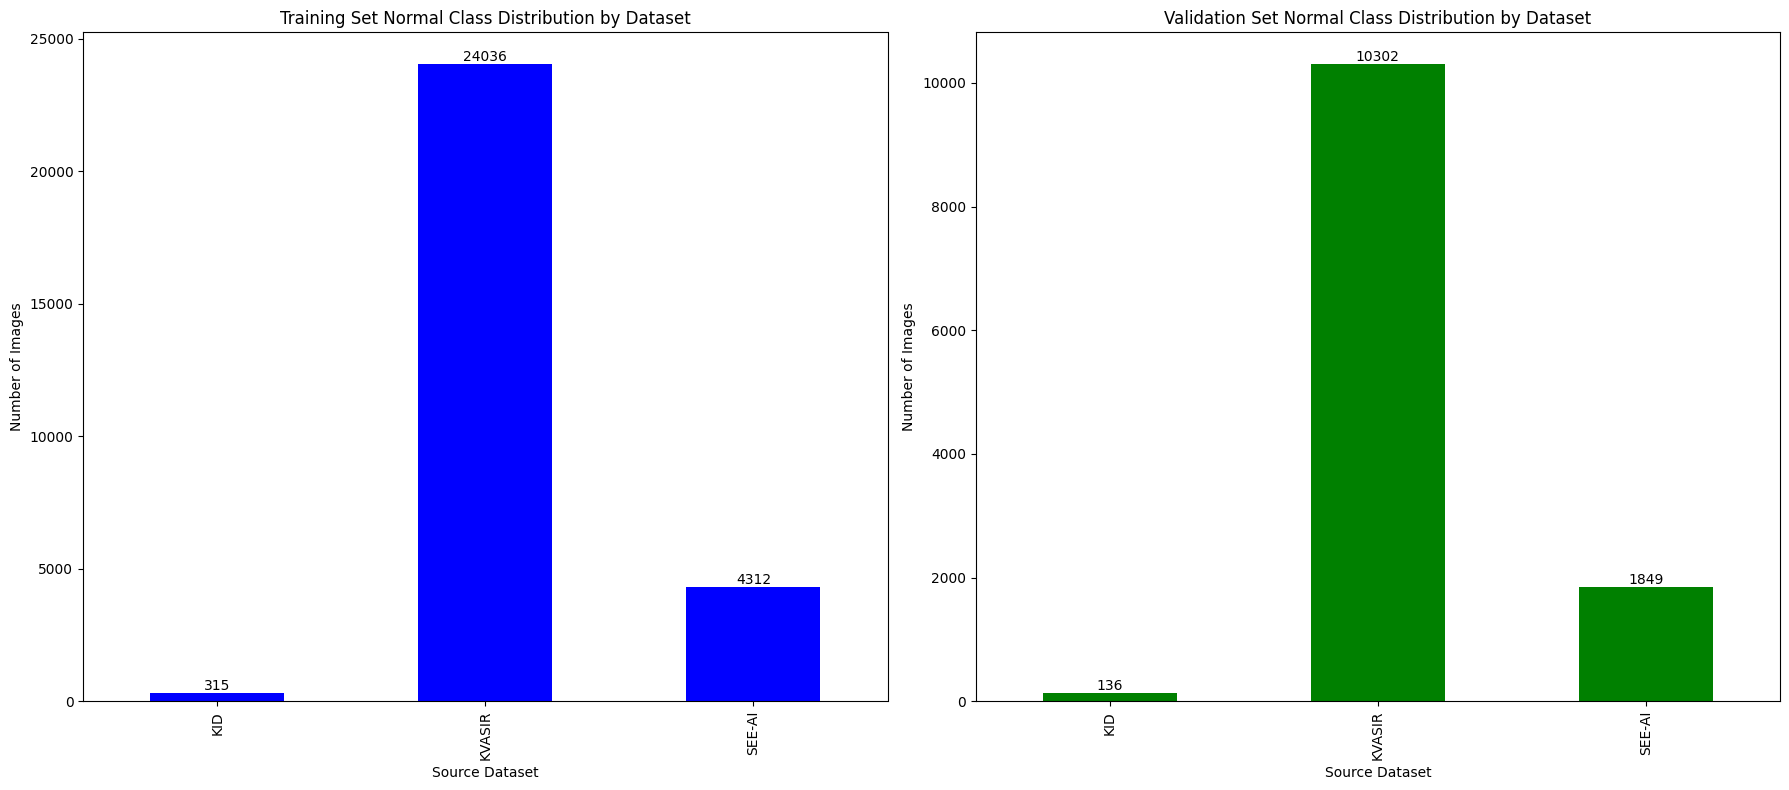

In [28]:
train_normal_df = train_df[train_df['Normal'] == 1]
val_normal_df = val_df[val_df['Normal'] == 1]

train_normal_distribution = train_normal_df.groupby('Dataset')['Normal'].count()
val_normal_distribution = val_normal_df.groupby('Dataset')['Normal'].count()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_normal_distribution.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Training Set Normal Class Distribution by Dataset')
ax[0].set_xlabel('Source Dataset')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_normal_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_normal_distribution.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Validation Set Normal Class Distribution by Dataset')
ax[1].set_xlabel('Source Dataset')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_normal_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph5.png')
plt.show()